In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

#### Disclaimer: some of the codes regarding SMOTE below are from the blog post
#### https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [94]:
!pip install imbalanced-learn

In [95]:
import imblearn
print(imblearn.__version__)

0.12.4


In [134]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [97]:
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [99]:
from glob import glob 
glob('*')

['main.ipynb',
 'Loan_Dataset.csv',
 'smote.ipynb',
 'README.md',
 'Loan_Dataset_final.csv',
 'Loan_Dataset_cleaned.csv']

In [100]:
df = pd.read_csv('Loan_Dataset_final.csv')

In [101]:
df.head()

,id,emp_length_num,Debt-To-Income Ratio,revol_util,od_ratio,bad_loan,annual_income_log,grade_A,grade_B,grade_C,...,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,total_rec_late_fee_cat_non-zero,total_rec_late_fee_cat_zero
0,11454641,1,26.27,43.2,0.160624,0,11.512935,True,False,False,...,False,False,False,False,True,False,False,True,False,True
1,9604874,4,5.39,21.5,0.810777,0,11.326608,True,False,False,...,False,False,False,False,True,False,True,False,False,True
2,9684700,11,18.45,46.3,0.035147,1,11.264477,False,False,False,...,False,False,False,False,False,True,False,True,False,True
3,9695736,6,12.28,10.7,0.534887,1,10.533082,False,False,False,...,False,False,False,False,False,True,True,False,False,True
4,9795013,11,11.26,15.2,0.166500,0,11.082158,False,False,False,...,False,False,False,False,True,False,True,False,False,True


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               18370 non-null  int64  
 1   emp_length_num                   18370 non-null  int64  
 2   Debt-To-Income Ratio             18370 non-null  float64
 3   revol_util                       18370 non-null  float64
 4   od_ratio                         18370 non-null  float64
 5   bad_loan                         18370 non-null  int64  
 6   annual_income_log                18370 non-null  float64
 7   grade_A                          18370 non-null  bool   
 8   grade_B                          18370 non-null  bool   
 9   grade_C                          18370 non-null  bool   
 10  grade_D                          18370 non-null  bool   
 11  grade_E                          18370 non-null  bool   
 12  grade_F           

#### Imbalanced Dataset

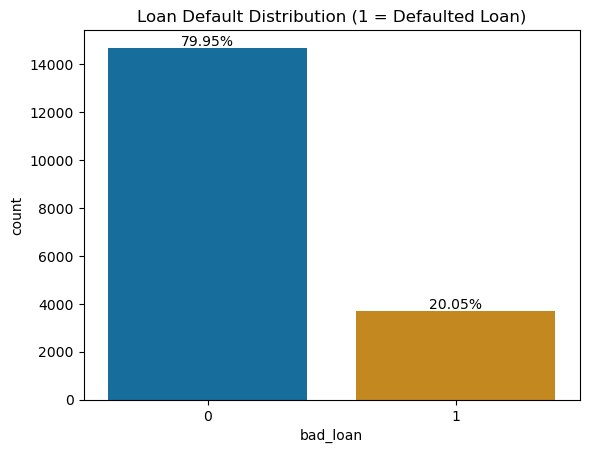

In [104]:
total_count = df.bad_loan.size

ax = sns.countplot(x='bad_loan', data=df, palette='colorblind')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

In [105]:
X = df.drop(columns=['id', 
                     'bad_loan',
                     'grade_A',
                     'home_ownership_MORTGAGE',
                     'purpose_car',
                     'term_36 months',
                     'last_delinq_none_0', 
                     'total_rec_late_fee_cat_zero'])

#1 represents bad loan. 0 represents good loan
y = df['bad_loan'].astype(int)

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   emp_length_num                   18370 non-null  int64  
 1   Debt-To-Income Ratio             18370 non-null  float64
 2   revol_util                       18370 non-null  float64
 3   od_ratio                         18370 non-null  float64
 4   annual_income_log                18370 non-null  float64
 5   grade_B                          18370 non-null  bool   
 6   grade_C                          18370 non-null  bool   
 7   grade_D                          18370 non-null  bool   
 8   grade_E                          18370 non-null  bool   
 9   grade_F                          18370 non-null  bool   
 10  grade_G                          18370 non-null  bool   
 11  home_ownership_OWN               18370 non-null  bool   
 12  home_ownership_REN

In [107]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = {0: class_weights[0], 1: class_weights[1]}

In [109]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(target_test, target_pred)
    
    print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}, Accuracy is {accuracy:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

<br> 
for the training data, will over sample the minority class to have 30% of the majoirity class, then use random undersamping to reduce the number of samples in the majority class to have 50% more than the minority class. test data's target distribution will stay the same.

In [111]:
X_train.shape

(14696, 27)

In [136]:
over = SMOTE(sampling_strategy=0.3)
X_over, y_over = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy=0.5)
X_train_resampled, y_train_resampled = under.fit_resample(X_over, y_over)

In [142]:
X_train_resampled.shape

(10575, 27)

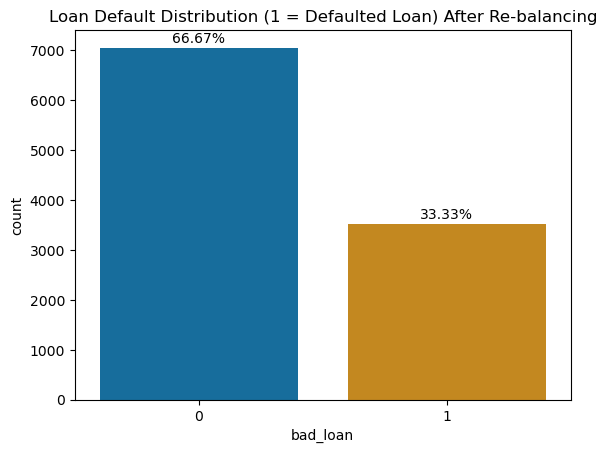

In [138]:
total_count = y_train_resampled.size

ax = sns.countplot(x=y_train_resampled, palette='colorblind')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan) After Re-balancing')
plt.show()

### Logistic Regression

In [221]:
param_grid = [{'C': [1, 10, 100, 1000]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                           #AP summarizes a precision-recall curve as the weighted mean of precisions achieved at 
                           #each threshold, with the increase in recall from the previous threshold used as the weight
                           #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
                          return_train_score = True)
               
grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'C': 1}

In [223]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train_resampled, y_train_resampled)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1913,1024
Actual Positive,246,491


In [225]:
lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.39. ROC AUC is 0.71, Accuracy is 0.65


In [227]:
lg_clf.coef_

array([[-0.06480738,  0.27674003,  0.14376573, -0.00989398, -0.30321617,
         0.26811071,  0.44384091,  0.49905231,  0.4110247 ,  0.35705081,
         0.16498685, -0.02861376,  0.08707666, -0.09521635, -0.08218275,
         0.05537073, -0.03486788,  0.03149887, -0.01062986, -0.02219982,
         0.01210163,  0.03070753, -0.00793206, -0.0230599 ,  0.16188996,
         0.03937473,  0.24612218]])

### XGBoost

In [230]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [232]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='aucpr',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 96}

In [233]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2899,38
Actual Positive,685,52


In [234]:
xgb_precision, xgb_recall, xgb_pr_auc, xgb_fpr, xgb_tpr, xgb_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.70, Accuracy is 0.80


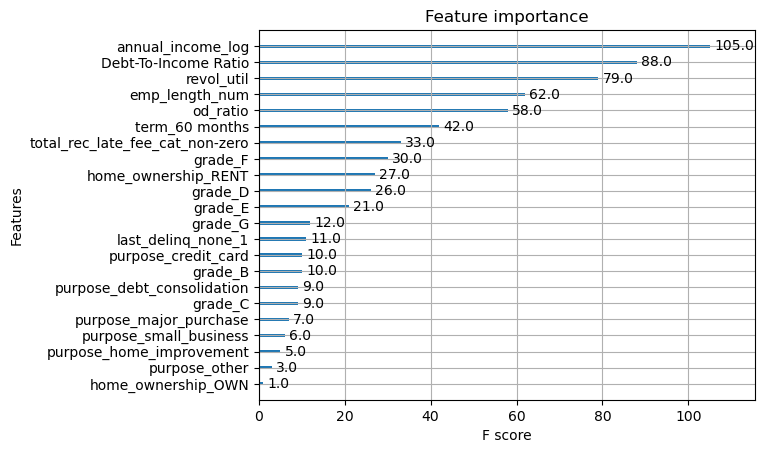

In [238]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [241]:
param_grid = [
    {'n_estimators': [440, 450, 460],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'max_depth': 15, 'n_estimators': 450}

In [242]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2655,282
Actual Positive,564,173


In [243]:
rf_precision, rf_recall, rf_pr_auc, rf_fpr, rf_tpr, rf_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.33. ROC AUC is 0.67, Accuracy is 0.77


In [244]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.18104964094425904),
 ('revol_util', 0.168991843478008),
 ('annual_income_log', 0.16527274190540112),
 ('od_ratio', 0.15841589847930346),
 ('emp_length_num', 0.09097425876623927),
 ('last_delinq_none_1', 0.026122237628554527),
 ('term_60 months', 0.02556494865143027),
 ('home_ownership_RENT', 0.02168711014945622),
 ('grade_B', 0.017838307939881986),
 ('purpose_debt_consolidation', 0.01758768387255882),
 ('grade_D', 0.015931808865109944),
 ('grade_C', 0.014304181366685117),
 ('purpose_credit_card', 0.013320628262997144),
 ('total_rec_late_fee_cat_non-zero', 0.012888861002786575),
 ('grade_E', 0.012183802435547677),
 ('home_ownership_OWN', 0.011551475300144866),
 ('grade_F', 0.010169373020521452),
 ('purpose_home_improvement', 0.008080124479948813),
 ('purpose_other', 0.00789940805814124),
 ('purpose_major_purchase', 0.004893184344090154),
 ('purpose_small_business', 0.004073314245074252),
 ('grade_G', 0.002507545643994346),
 ('purpose_medical', 0.0021722318489

### Gradient Descent Optimization

Stochastic Gradient Descent

In [247]:
param_grid = [
    {'max_iter': list(range(50, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'max_iter': 150}

In [248]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train_resampled, y_train_resampled)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1773,1164
Actual Positive,259,478


In [249]:
sgd_precision, sgd_recall, sgd_pr_auc, sgd_fpr, sgd_tpr, sgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.35. ROC AUC is 0.67, Accuracy is 0.61


Mini-batch Gradient Descent

In [251]:
from sklearn.base import clone

batch_size = 150
sample_size = len(X_train_resampled)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train_resampled, y_train_resampled))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train_resampled[list(train_ind)], y_train_resampled.iloc[train_ind], X_train_resampled[list(val_ind)], y_train_resampled.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


,Predicted Negative,Predicted Positive
Actual Negative,1773,1164
Actual Positive,259,478


In [252]:
mbgd_precision, mbgd_recall, mbgd_pr_auc, mbgd_fpr, mbgd_tpr, mbgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.35. ROC AUC is 0.67, Accuracy is 0.61


### Support Vector Machine

Linear SVM

In [255]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(10, 20, 2)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123,
                        class_weight='balanced')

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'C': 10, 'max_iter': 5}

In [256]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train_resampled, y_train_resampled)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train_resampled, y_train_resampled)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1905,1032
Actual Positive,245,492


In [257]:
lsvm_precision, lsvm_recall, lsvm_pr_auc, lsvm_fpr, lsvm_tpr, lsvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.39. ROC AUC is 0.71, Accuracy is 0.65


Polynomial Kernel Support Vector Classifier

SVC's time complexity is $O(n^2 \times d)$ to $O(n^3 \times d)$. To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [271]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X_train_resampled, y_train_resampled,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X_train_resampled[train_ind], y_train_resampled[train_ind], X_train_resampled[test_ind], y_train_resampled[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test = scaler.transform(X_test)

In [273]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True,
                          class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 100, 'coef0': 1, 'degree': 1}

In [275]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test)
y_score = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1797,1140
Actual Positive,229,508


In [279]:
pksvm_precision, pksvm_recall, pksvm_pr_auc, pksvm_fpr, pksvm_tpr, pksvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.70, Accuracy is 0.63


Gaussian RBF Kernel Support Vector Classifier

In [281]:
param_grid = [
    {'gamma': [0.001, 0.01, 0.1, 1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True,
                         class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 0.1, 'gamma': 0.001}

In [285]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test)
y_score = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2338,599
Actual Positive,402,335


In [287]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc, rbfksvm_fpr, rbfksvm_tpr, rbfksvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.70, Accuracy is 0.73


### Stacking/Stacked Generalization

In [289]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train_resampled, y_train_resampled)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1844,1093
Actual Positive,254,483


In [290]:
stack_precision, stack_recall, stack_pr_auc, stack_fpr, stack_tpr, stack_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.36. ROC AUC is 0.69, Accuracy is 0.63


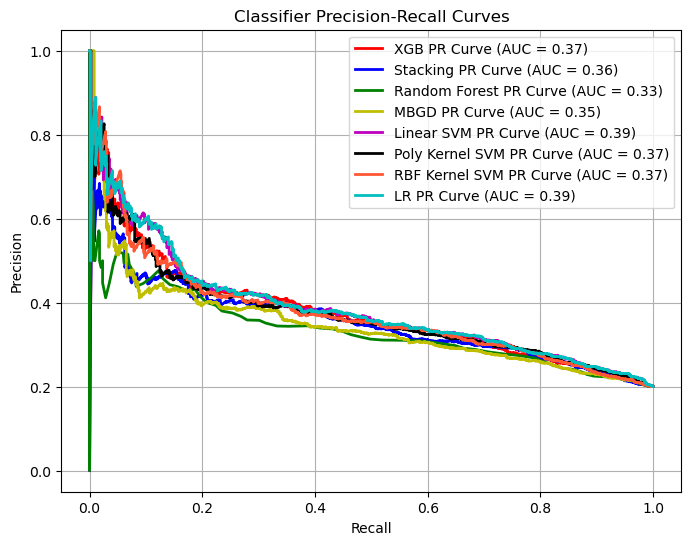

In [291]:
plt.figure(figsize=(8, 6))


plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

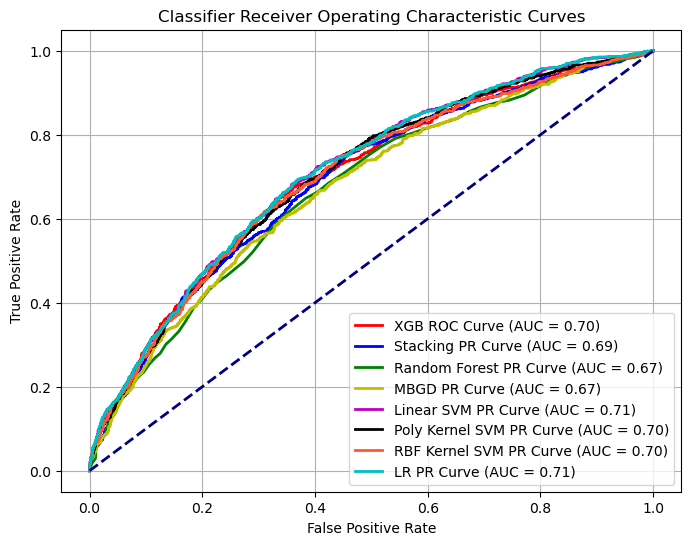

In [292]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_fpr, xgb_tpr, color='r', lw=2, label=f'XGB ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot(stack_fpr, stack_tpr, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_roc_auc:.2f})')
plt.plot(mbgd_fpr, mbgd_tpr, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_roc_auc:.2f})')
plt.plot(lsvm_fpr, lsvm_tpr, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_roc_auc:.2f})')
plt.plot(pksvm_fpr, pksvm_tpr, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_roc_auc:.2f})')
plt.plot(rbfksvm_fpr, rbfksvm_tpr, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_roc_auc:.2f})')
plt.plot(lg_fpr, lg_tpr, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Receiver Operating Characteristic Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Using SMOTE to rebalance the training data does not help with classifiers' performances. In unsupervised.ipynb, I will try to relabel the dataset.